In [80]:
%matplotlib notebook
import sys
from functools import reduce
from itertools import product
from tqdm import tqdm
from  pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import  transforms
from netgraph import Graph, InteractiveGraph, EditableGraph,get_sugiyama_layout

In [81]:
def isproperpart(first, second):
    return first.issubset(second) and (first != second)

def fuse(pair):
    return pair[0] | pair[1]

def minimize(stateset):
    listset = sorted(stateset, key = len, reverse = True)
    n = 0
    while n < len(listset):
        for test in listset:
            if isproperpart(test,listset[n]):
                listset.pop(n)
                n = n-1
                continue
        n = n+1
    return frozenset(listset)
def propsfromlist(props):
    return [propfromstring(prop) for prop in props]

def propfromstring(string):
    components = string.split('|')
    return tuple([unipropfromstring(prop) for prop in components])

def unipropfromstring(string):
    bits = string.split(';')
    return (statesetfromstring(bits[0]),statefromstring(bits[1]))

def statefromstring(string):
    return frozenset(string)

def statesetfromstring(string):
    states = string.split(' ')
    return minimize([statefromstring(state) for state in states])

def posetfromlist(list, test, wrapper = lambda x: x):
    poset = nx.DiGraph()
    poset.add_nodes_from([item for item in list])
    for x in list: 
        for y in list:
            if x!=y and test(x,y):
                poset.add_edge(x,y)
    return poset

def bottomwedge(first, second):
    return minimize(map(fuse, product(first, second)))

def bottomvee(first, second):
    return minimize(first | second)     

def wedge(first, second):
    return (bottomwedge(first[0],second[0]),fuse([first[1],second[1]]))
    
def vee(first,second):
    return (bottomvee(first[0],second[0]),fuse([first[1],second[1]]))
        
def conjoin(first, second):
    return (wedge(first[0], second[0]), vee(first[1], second[1]))

def disjoin(first, second):
    return (vee(first[0], second[0]), wedge(first[1], second[1]))

def negate(x):
    return (x[1], x[0])

def negclose(c):
    n = 0
    while n < len(c):
        new = negate(c[n])
        if not (new in c):
            c.append(new) 
        n = n+1
    return c

def isconjunct(first,second):
    return conjoin(first,second) == second
    
def conjclose(c):
    n = 0
    while n < len(c):
        m = 0
        while m < n:
            new = conjoin(c[m], c[n])
            if not (new in c):
                c.append(new)
            m = m+1
        n = n+1
    return c

# Finally disjunction, which is just the same:
def stateasstring(state):
    return "".join(sorted(state, reverse = True))

def disjclose(c):
    n = 0
    while n < len(c):
        m = 0
        while m < n:
            new = disjoin(c[m], c[n])
            if not (new in c):
                c.append(new)
            m = m+1
        n = n+1
    return c
def mysortkey(state):
    return (10-len(state), stateasstring(state))
def statesetasstring(stateset):
    thelist = sorted(stateset, key = mysortkey, reverse = True)
    return ",".join([stateasstring(state) for state in thelist])
def Lpropasstring(prop):
    return statesetasstring(prop[0][0])+'|'+statesetasstring(prop[1][0])

def close(c):
    return(disjclose(conjclose(negclose(c))))

def detransitivize(poset):
    return nx.transitive_reduction(poset)

def stringify(graph):
    return [(Lpropasstring(edge[0]),Lpropasstring(edge[1])) for edge in graph.edges]

def to_dot( E ):
    res = [ 'digraph G { rankdir = BT; ' ]
    res.extend( [ '"{}"->"{}";'.format( *e ) for e in E ] )
    res.append( '}' )
    return '\n'.join( res )

In [92]:
atoms = propsfromlist(['r;r|g b;gb','g;g|r b;rb','b;b|r g;rg'])
propositions = close(atoms)
pairs = posetfromlist(propositions,isconjunct)
pairs = detransitivize(pairs)

<IPython.core.display.Javascript object>


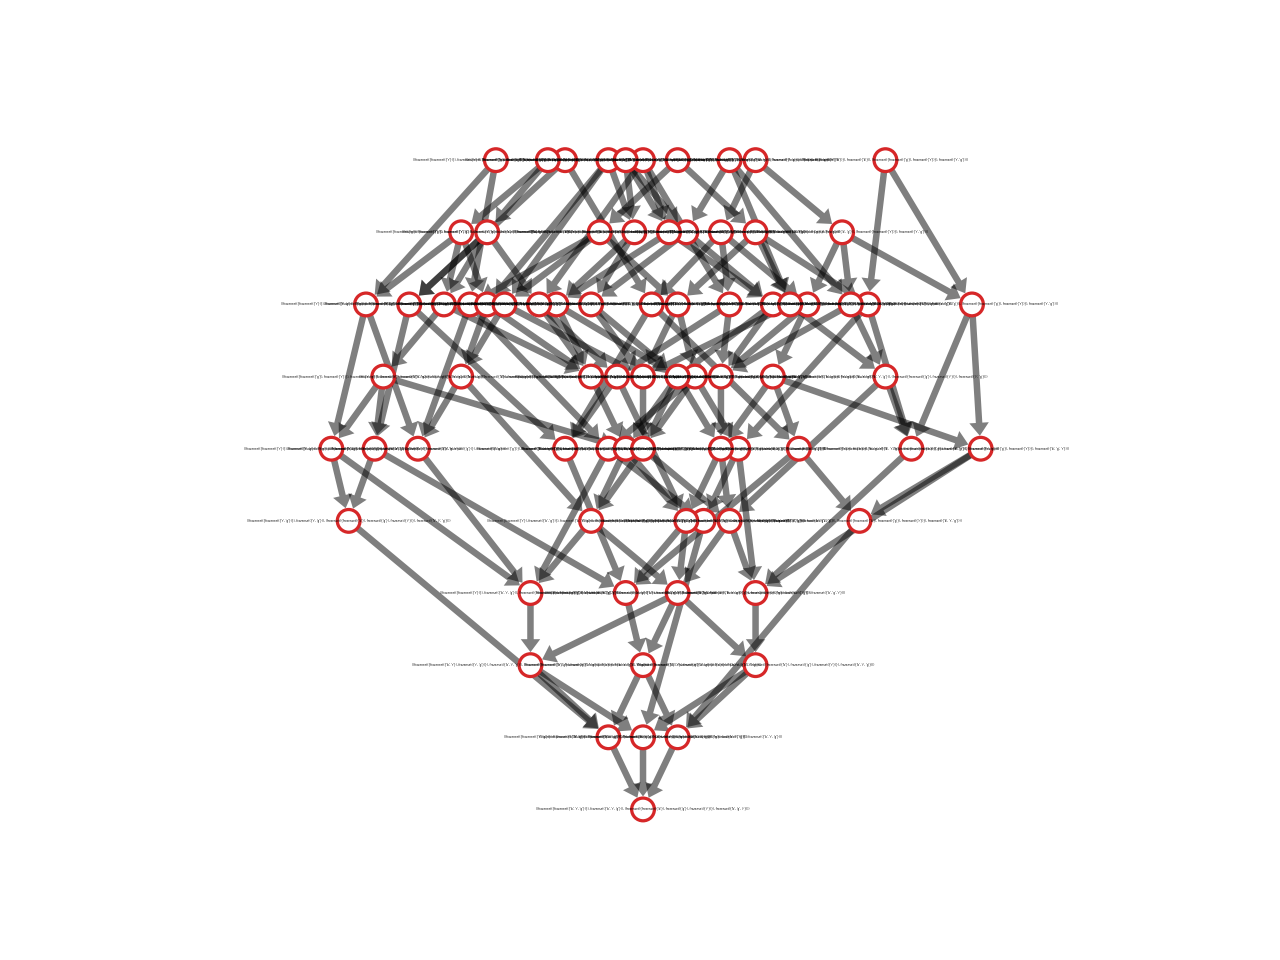

In [93]:
plot_instance = InteractiveGraph(pairs,node_size = 2,
                                 node_color='w',
                                 node_layout=node_position,
                                 node_labels = True,
                                 node_edge_color = 'tab:red',
                                 node_label_fontdict=dict(size=1),
                                 edge_layout='straight',
                                 edge_color='black',
                                 edge_width = 1,
                                 arrows = True,
                                 edge_label_rotate = True,
                                 directed = True
                                 )
